In [1]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
import seaborn as sns
from cycler import cycler

%matplotlib ipympl


from skfda import FDataGrid
from skfda.representation.basis import BSpline
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.registration import ElasticRegistration, landmark_registration


# plt.style.use('dark_background')
plt.style.use('default')

In [2]:

res = pd.read_csv(
	'./segmented-data-v1-1.csv',
	dtype={
		'img_type': int,
		'patient_id': int,
		'cycle_id': int,
		'slice_id': int,
		'confirmed_cancer': bool,
		'unconfirmed_cancer': bool,
		'benign': bool,
		'mask_int_mean': float,
		'segment': int,
	},
)

groups = {
	lambda x: x['confirmed_cancer']: 'red',
	lambda x: x['unconfirmed_cancer']: 'orange',
	lambda x: x['benign']: 'green',
	lambda x: True: 'grey',
}


In [3]:
inspect = res.query('patient_id == 66 and slice_id == 12 and segment == 6')

<AxesSubplot:xlabel='t', ylabel='intensity'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
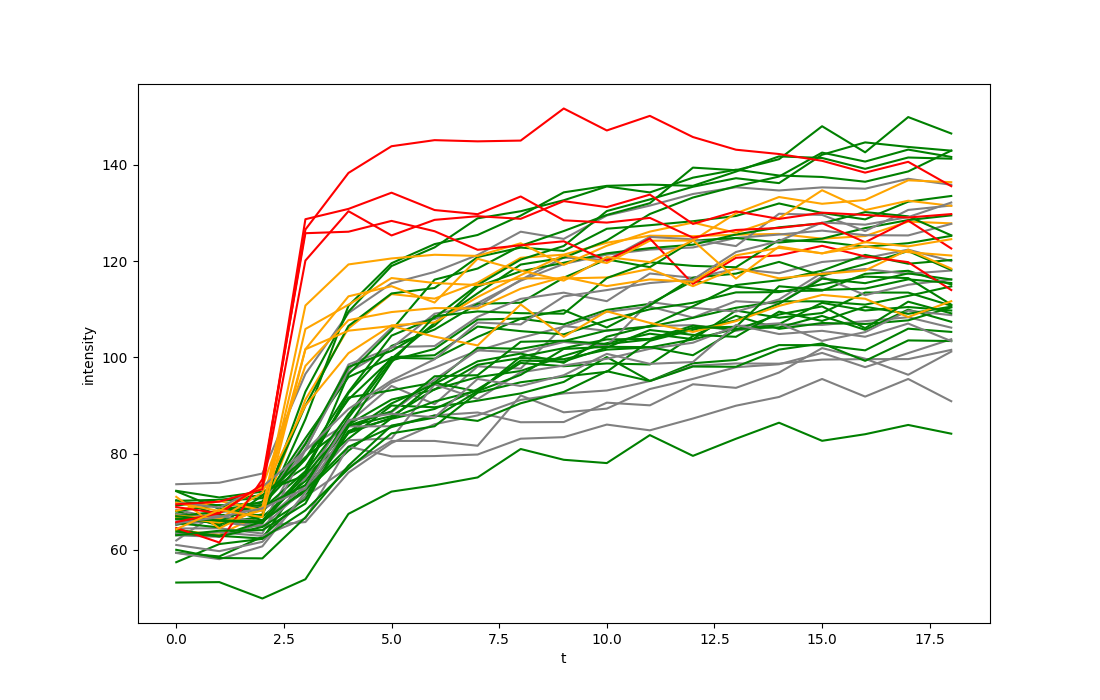

In [13]:
order = inspect[['img_type', 'confirmed_cancer', 'unconfirmed_cancer', 'benign']].drop_duplicates()
pallete = order.apply(
	lambda x: [color for condition, color in groups.items() if condition(x)][0],
	axis='columns',
).tolist()
order = order['img_type'].tolist()

plt.close()
fig = plt.figure(figsize=(11, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = plt.axes(
	ylabel='intensity',
	xlabel='t',
)
sns.lineplot(
	x='cycle_id', y='mask_int_mean', hue='img_type',
	hue_order=order, palette=pallete, legend=False, data=inspect, ax=ax,
)


In [5]:
agg_columns = ['patient_id', 'slice_id', 'img_type']

n_basis=18
# n_basis=12
order=4

basis = BSpline(domain_range=(0, 1), n_basis=n_basis, order=order)
smoother = BasisSmoother(basis=basis, return_basis=True, method='svd')

ts = np.linspace(0, 1, inspect.cycle_id.drop_duplicates().count())
intensities = (
	inspect.sort_values(agg_columns + ['cycle_id'])
		.groupby(agg_columns)
		.mask_int_mean.apply(list).reset_index().mask_int_mean.tolist()
)

bsplined = smoother.fit_transform(FDataGrid(data_matrix=intensities, grid_points=ts))


In [8]:
prc_rm=0.05
n_points=100


def cut_ends(bsplined, order=0, prc_rm_start=prc_rm, prc_rm_end=prc_rm, n_points=n_points):
	bsplined_grid = bsplined.derivative(order=order).to_grid(np.linspace(0, 1, n_points))
	return FDataGrid(
		data_matrix=bsplined_grid.data_matrix[
			..., int(n_points * prc_rm_start): int(n_points * (1 - prc_rm_end)), 0
		],
		grid_points=bsplined_grid.grid_points[0][
			int(n_points * prc_rm_start): int(n_points * (1 - prc_rm_end))
		]
	)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
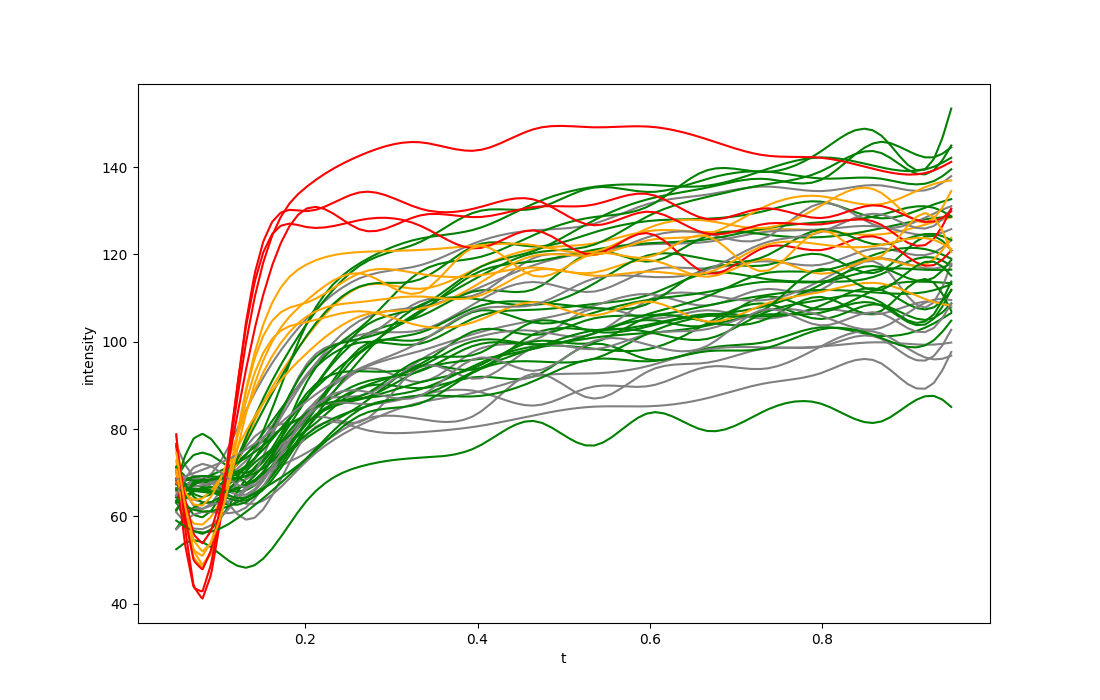

In [14]:
plt.close()
fig = plt.figure(figsize=(11, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = plt.axes(
	ylabel='intensity',
	xlabel='t',
)
order = (
	inspect[['img_type', 'confirmed_cancer', 'unconfirmed_cancer', 'benign']]
		.drop_duplicates()
		.sort_values('img_type')
		.apply(
			lambda x: [color for condition, color in groups.items() if condition(x)][0],
			axis='columns',
		)
		.tolist()
)
pallete = order
color_cycle = cycler(color=pallete)
ax.set_prop_cycle(color_cycle)
plotted = cut_ends(bsplined, 0).plot(fig=fig, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
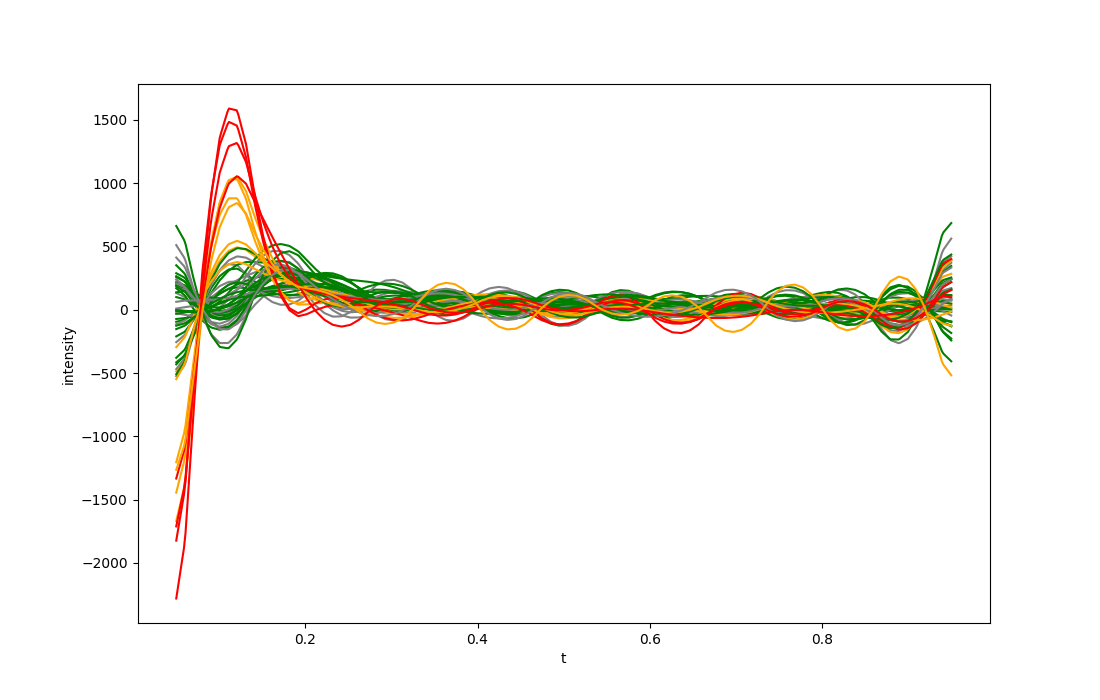

In [15]:
plt.close()
fig = plt.figure(figsize=(11, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = plt.axes(
	ylabel='intensity',
	xlabel='t',
)
color_cycle = cycler(color=pallete)
ax.set_prop_cycle(color_cycle)
plotted = cut_ends(bsplined, 1).plot(fig=fig, ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
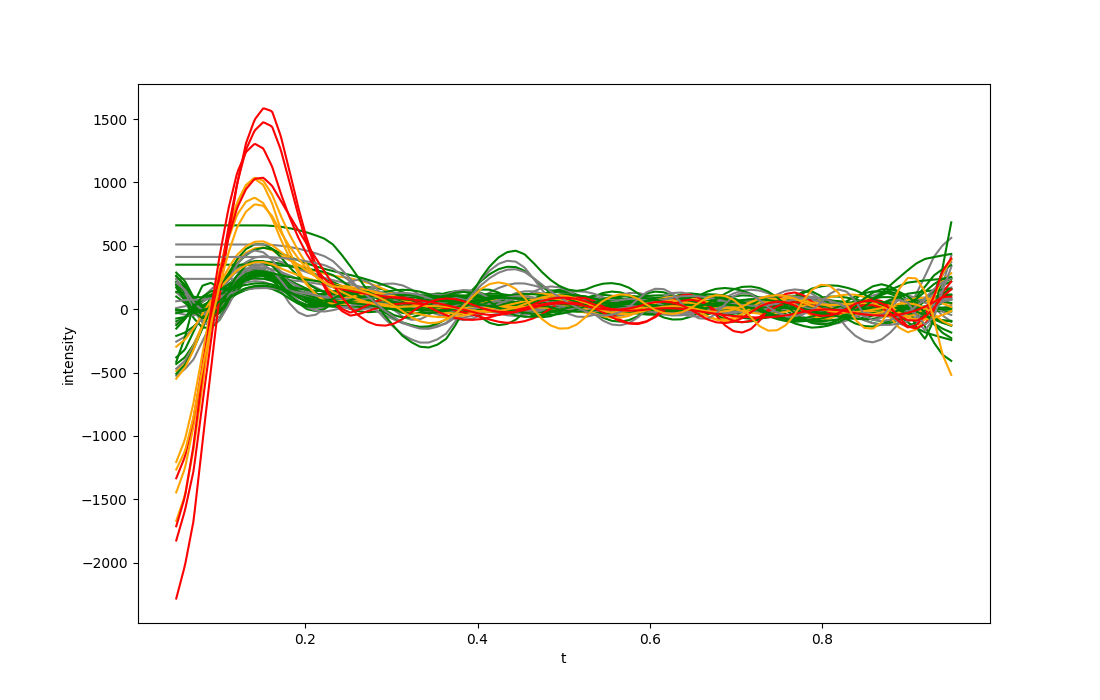

In [16]:
registration = ElasticRegistration()


def get_landmark_registration(bsplined, order=0):
	bsplined_grid = cut_ends(bsplined, order)
	landmark_indexes = cut_ends(bsplined, order, prc_rm_end=0.5).data_matrix.argmax(axis=1)
	grid_points = bsplined_grid.grid_points[0]
	landmarks = [grid_points[index] for index in np.concatenate(landmark_indexes)]
	return landmark_registration(bsplined_grid, landmarks)


plt.close()
fig = plt.figure(figsize=(11, 7))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
ax = plt.axes(
	ylabel='intensity',
	xlabel='t',
)
color_cycle = cycler(color=pallete)
ax.set_prop_cycle(color_cycle)
plotted = get_landmark_registration(bsplined, 1).plot(fig=fig, ax=ax)

In [1]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import pyperclip

In [54]:
file = './show/registered_discrete_50_slic_zones_no_cv.csv'

registered = 'un' if 'unregistered' in file else ''
model = 'Flat Neural network' if 'nn_' in file else 'XGboost classification'
features = (
	'100 discrete values of functional data, maximum values, integral depth and maximum band depth'
	if '_all_' in file else 'only 100 discrete values of functional data'
)
slic_region_prop = (
	'for each slice is 50'
	if '_50_slic_zones_' in file else 'in each slice is proportionate to it\'s size'
)

label_model = 'nn' if 'nn_' in file else 'xgb'
label_registered = 'un' if '/unregistered_' in file else ''
label_features = 'all' if '_all_' in file else 'disc'
label_slic_region_prop = 'un' if '_50_slic_zones_' in file else ''

label = (
	f'{label_model}_{label_registered}reg_{label_features}_{label_slic_region_prop}prop'
)
description = (
	f'Classification accuracy metrics of validation set for {model} '
	f'model. Features for dataset is extracted from {registered}registered functional data'
	f'. Extracted features - {features}. Number of SLIC regions {slic_region_prop}'
)

pyperclip.copy(
	'\\begin{table*}[tbp]\n' +
	f'\\caption{{{description}}}\n' +
	f'\\label{{table:{label}}}\n' +
	'\\centering\n' +
	tabulate(
		pd.read_csv(file)
			.drop('segmentation_id', axis='columns'),
		tablefmt='latex', headers='keys', floatfmt='.3g', showindex=False,
	) +
	'\n\\end{table*}\n'
)


In [21]:
tables = [
	pd.read_csv(file)
		# .filter(regex='^(patient_id|.*_(mean|std))$', axis='columns')
		.filter(
			regex='^(patient_id|neuron_number_\d+|level|activation_function)$',
			axis='columns'
		)
		.assign(
			registered='/unregistered_' not in file,
			only_discrete='_discrete_' in file,
			# fixed_number_of_slic_regions='_50_slic_zones_' not in file,
		)
	for file in [
		# './show/registered_discrete_50_slic_zones_no_cv.csv',
		# './show/registered_all_50_slic_zones_no_cv.csv',
		# './show/unregistered_discrete_50_slic_zones_no_cv.csv',
		# './show/unregistered_all_50_slic_zones_no_cv.csv',
		
		# './show/registered_discrete_f1_no_cv.csv',
		# './show/registered_all_f1_no_cv.csv',
		# './show/unregistered_discrete_f1_no_cv.csv',
		# './show/unregistered_all_f1_no_cv.csv',
		
		'./show/nn_registered_discrete_50_slic_zones_no_cv.csv',
		'./show/nn_registered_all_50_slic_zones_no_cv.csv',
		'./show/nn_unregistered_discrete_50_slic_zones_no_cv.csv',
		'./show/nn_unregistered_all_50_slic_zones_no_cv.csv',
		
		# './show/nn_registered_discrete_no_cv.csv',
		# './show/nn_registered_all_no_cv.csv',
		# './show/nn_unregistered_discrete_no_cv.csv',
		# './show/nn_unregistered_all_no_cv.csv',
	]
]
# label = 'xgb_50'
# description = (
# 	'Classification accuracy metrics of validation set for XGboost classification model. '
# 	'For each slice number of SLIC regions is 50'
# )
# label = 'xgb_prop'
# description = (
# 	'Classification accuracy metrics of validation set for XGboost classification model. '
# 	'For each slice number of SLIC regions is proportionate to it\'s size'
# )
label = 'nn_50_params'
# label = 'nn_50'
description = (
	'Classification accuracy metrics of validation set for flat neural network model. '
	'For each slice number of SLIC regions is 50'
)
# label = 'nn_prop'
# label = 'nn_prop_params'
# description = (
# 	'Classification accuracy metrics of validation set for flat neural network model. '
# 	'For each slice number of SLIC regions is proportionate to it\'s size'
# )
tables = pd.concat(tables)
col_format = '|'.join(['c'] * tables.shape[1])
tables.columns = [col.replace("_", " ") for col in tables.columns]
tables = (
	tables.set_index(
		[
			'registered', 'only discrete',
			# 'fixed number of slic regions',
			'patient id'
		]
	)
		# .drop('segmentation id', axis='columns')
)
pyperclip.copy(
# print(
	'\\begin{table*}[tbp]\n' +
	f'\\caption{{{description}}}\n' +
	f'\\label{{table:{label}}}\n' +
	'\\centering\n' +
	tables.to_latex(float_format='%0.4g', column_format=col_format, escape=False, multicolumn=True, multirow=True, na_rep='') +
	'\n\\end{table*}\n'
)

In [2]:
def nn_metrics(file):
	return (
		pd.read_csv(file)
			.filter(regex='^.*_(mean|std)$', axis='columns')
			.median()
			.to_frame()
			.transpose()
	)


def nn_params(file):
	nn_results = pd.read_csv(file)
	return (
		nn_results[
			nn_results.balanced_accuracy_mean.max() == nn_results.balanced_accuracy_mean
		]
		.filter(regex='^(neuron_number_\d+|activation_function)$', axis='columns')
	)


def xgb_results(file):
	xgb_results = pd.read_csv(file)
	return (
		xgb_results
			[['precision', 'recall', 'f1', 'balanced_accuracy', 'specificity']]
			.median()
			.to_frame()
			.transpose()
			.assign(join_col=1)
			.merge(
				xgb_results[
					xgb_results.balanced_accuracy.max() == xgb_results.balanced_accuracy
				]
				[[
					'colsample_bytree', 'gamma', 'max_depth','min_child_weight',
					'reg_alpha'
				]]
				.assign(join_col=1).head(1)
			)
			.drop('join_col', axis='columns')
	)


tables = [
	# nn_params(file)
	nn_metrics(file)
	# xgb_results(file)
		.assign(
			registered='unregistered_' not in file,
			only_discrete='_discrete_' in file,
			fixed_number_of_slic_regions='_50_slic_zones_' in file,
		)
	for file in [
# 		'./show/registered_discrete_50_slic_zones_no_cv.csv',
# 		'./show/registered_all_50_slic_zones_no_cv.csv',
# 		'./show/unregistered_discrete_50_slic_zones_no_cv.csv',
# 		'./show/unregistered_all_50_slic_zones_no_cv.csv',
		
# 		'./show/registered_discrete_f1_no_cv.csv',
# 		'./show/registered_all_f1_no_cv.csv',
# 		'./show/unregistered_discrete_f1_no_cv.csv',
# 		'./show/unregistered_all_f1_no_cv.csv',
		
		'./show/nn_registered_discrete_50_slic_zones_no_cv.csv',
		'./show/nn_registered_all_50_slic_zones_no_cv.csv',
		'./show/nn_unregistered_discrete_50_slic_zones_no_cv.csv',
		'./show/nn_unregistered_all_50_slic_zones_no_cv.csv',
		
		'./show/nn_registered_discrete_no_cv.csv',
		'./show/nn_registered_all_no_cv.csv',
		'./show/nn_unregistered_discrete_no_cv.csv',
		'./show/nn_unregistered_all_no_cv.csv',
	]
]
# label = 'xgb'
# description = (
# 	'Classification accuracy metrics of validation set for XGboost classification model. '
# )
# label = 'nn_params'
label = 'nn'
# description = (
# 	'Classification accuracy metrics of validation set for flat neural network model. '
# )
tables = pd.concat(tables).sort_values(
	['registered', 'only_discrete', 'fixed_number_of_slic_regions']
)
col_format = '|'.join(['c'] * (tables.shape[1] - 1))
tables.columns = [col.replace("_", " ") for col in tables.columns]
tables = tables.set_index(['registered', 'only discrete', 'fixed number of slic regions'])
pyperclip.copy(
# print(
	# '\\begin{table*}[tbp]\n' +
	# f'\\caption{{{description}}}\n' +
	# f'\\label{{table:{label}}}\n' +
	# '\\centering\n' +
	tables.to_latex(float_format='%0.3f', column_format=col_format, escape=False, multicolumn=True, multirow=True, na_rep='') +
	'\n\\end{table*}\n'
)
tables

precision mean  \
registered only discrete fixed number of slic regions                   
False      False         False                               0.368652   
                         True                                0.279117   
           True          False                               0.352794   
                         True                                0.332013   
True       False         False                               0.331667   
                         True                                0.181101   
           True          False                               0.282493   
                         True                                0.185781   

                                                       precision std  \
registered only discrete fixed number of slic regions                  
False      False         False                              0.060844   
                         True                               0.052394   
           True          False                              0.074364   
                         True                               0.041403   
True       False         False                              0.086821   
                         True                               0.060549   
           True          False                              0.077827   
                         True                               0.046544   

                                                       recall mean  \
registered only discrete fixed number of slic regions                
False      False         False                            0.650000   
                         True                             0.733333   
           True          False                            0.633333   
                         True                             0.737838   
True       False         False                            0.642308   
                         True                             0.660000   
           True          False                            0.685714   
                         True                             0.666667   

                                                       recall std   f1 mean  \
registered only discrete fixed number of slic regions                         
False      False         False                           0.070956  0.442097   
                         True                            0.084327  0.391167   
           True          False                           0.090655  0.412908   
                         True                            0.113529  0.395343   
True       False         False                           0.144938  0.392688   
                         True                            0.140546  0.270293   
           True          False                           0.112687  0.363611   
                         True                            0.076478  0.267501   

                                                         f1 std  \
registered only discrete fixed number of slic regions             
False      False         False                         0.045524   
                         True                          0.039980   
           True          False                         0.059122   
                         True                          0.043431   
True       False         False                         0.077062   
                         True                          0.043876   
           True          False                         0.076882   
                         True                          0.037904   

                                                       balanced accuracy mean  \
registered only discrete fixed number of slic regions                           
False      False         False                                       0.772025   
                         True                                        0.831404   
           True          False                                       0.784044   
                         True      

In [146]:
from scipy import stats
import re

files = [
	'./show/registered_discrete_50_slic_zones_no_cv.csv',
	'./show/registered_all_50_slic_zones_no_cv.csv',
	'./show/unregistered_discrete_50_slic_zones_no_cv.csv',
	'./show/unregistered_all_50_slic_zones_no_cv.csv',

	'./show/registered_discrete_f1_no_cv.csv',
	'./show/registered_all_f1_no_cv.csv',
	'./show/unregistered_discrete_f1_no_cv.csv',
	'./show/unregistered_all_f1_no_cv.csv',

	'./show/nn_registered_discrete_50_slic_zones_no_cv.csv',
	'./show/nn_registered_all_50_slic_zones_no_cv.csv',
	'./show/nn_unregistered_discrete_50_slic_zones_no_cv.csv',
	'./show/nn_unregistered_all_50_slic_zones_no_cv.csv',

	'./show/nn_registered_discrete_no_cv.csv',
	'./show/nn_registered_all_no_cv.csv',
	'./show/nn_unregistered_discrete_no_cv.csv',
	'./show/nn_unregistered_all_no_cv.csv',
]

def extract_configuration(file, conf_x, conf_y):
	f = re.sub(f'{conf_x}|{conf_y}', '', file)
	result = { 'file': file }
	if conf_x != 'unregistered':
		result['registered'] = 'unregistered' if 'unregistered' in f else 'registered'
	if conf_x != 'nn_':
		result['model'] = 'Flat NN' if 'nn_' in f else 'XGboost'
	if conf_x != '_all_':
		result['features'] = 'Not only discrete' if '_all_' in f else 'only discrete'
	if conf_x != '50_slic_zones_':
		result['slic_zones'] = (
			'fixed number of SLIC regions'
			if '50_slic_zones_' in f else 'proportionate number of SLIC regions'
		)
	return result


def get_balanced_acc(file):
	suff = ''
	if 'nn_' in file:
		suff = '_mean'
	return pd.read_csv(file).sort_values('patient_id')['balanced_accuracy' + suff].tolist()


def get_p_value(file_pair):
	balanced_acc = [get_balanced_acc(file) for file in file_pair]
	return stats.wilcoxon(*balanced_acc)[1]


def get_configuration_matches(conf_x, conf_y):
	result = pd.DataFrame([extract_configuration(file, conf_x, conf_y) for file in files])
	columns = result.columns.tolist()
	columns.remove('file')
	return result.groupby(columns).file.apply(list).apply(get_p_value).reset_index()

(
	get_configuration_matches('unregistered', 'registered').rename({'file': 'unregistered vs registered'}, axis='columns')
		.merge(
			get_configuration_matches('nn_', '').rename({'file': 'flat NN vs XGBoost'}, axis='columns'),
			on=['features', 'slic_zones'],
		)
		.merge(
			get_configuration_matches('_all_', '_discrete_').rename({'file': 'all features vs discrete only'}, axis='columns'),
			on=['model', 'slic_zones', 'registered'],
		)
		.merge(
			get_configuration_matches('50_slic_zones_', '').rename({'file': 'fixed vs proportionate number of SLiC regions'}, axis='columns'),
			on=['features', 'model', 'registered'],
		)
)


C:\Users\Aleksas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,model,features,slic_zones,unregistered vs registered,registered,flat NN vs XGBoost,all features vs discrete only,fixed vs proportionate number of SLiC regions
0,Flat NN,Not only discrete,fixed number of SLIC regions,0.010498,registered,0.946045,0.127197,0.839355
1,Flat NN,Not only discrete,proportionate number of SLIC regions,0.021484,registered,0.339600,0.375732,0.839355
2,Flat NN,only discrete,fixed number of SLIC regions,0.002441,registered,0.216309,0.127197,0.454834
3,Flat NN,only discrete,proportionate number of SLIC regions,0.497314,registered,0.339600,0.375732,0.454834
4,Flat NN,Not only discrete,fixed number of SLIC regions,0.010498,unregistered,0.839355,0.839355,0.735352
5,Flat NN,Not only discrete,proportionate number of SLIC regions,0.021484,unregistered,0.157939,0.182338,0.735352
6,Flat NN,only discrete,fixed number of SLIC regions,0.002441,unregistered,0.541748,0.839355,0.414307
7,Flat NN,only discrete,proportionate number of SLIC regions,0.497314,unregistered,0.247746,0.182338,0.414307
8,XGboost,Not only discrete,fixed number of SLIC regions,0.213223,registered,0.946045,0.444587,0.305420
9,XGboost,Not only discrete,proportionate number of SLIC regions,0.216309,registered,0.339600,0.213223,0.305420


In [171]:
from scipy import stats
import re

files = [
	'./show/registered_discrete_50_slic_zones_no_cv.csv',
	'./show/registered_all_50_slic_zones_no_cv.csv',
	'./show/unregistered_discrete_50_slic_zones_no_cv.csv',
	'./show/unregistered_all_50_slic_zones_no_cv.csv',

	'./show/registered_discrete_f1_no_cv.csv',
	'./show/registered_all_f1_no_cv.csv',
	'./show/unregistered_discrete_f1_no_cv.csv',
	'./show/unregistered_all_f1_no_cv.csv',

	'./show/nn_registered_discrete_50_slic_zones_no_cv.csv',
	'./show/nn_registered_all_50_slic_zones_no_cv.csv',
	'./show/nn_unregistered_discrete_50_slic_zones_no_cv.csv',
	'./show/nn_unregistered_all_50_slic_zones_no_cv.csv',

	'./show/nn_registered_discrete_no_cv.csv',
	'./show/nn_registered_all_no_cv.csv',
	'./show/nn_unregistered_discrete_no_cv.csv',
	'./show/nn_unregistered_all_no_cv.csv',
]

def extract_configuration(file):
	result = { 'file': file }
	result['registered'] = 'unregistered' if 'unregistered' in file else 'registered'
	result['model'] = 'Flat NN' if 'nn_' in file else 'XGboost'
	result['features'] = 'Not only discrete' if '_all_' in file else 'only discrete'
	result['slic_zones'] = (
		'fixed number of SLIC regions'
		if '50_slic_zones_' in file else 'proportionate number of SLIC regions'
	)
	return result


def get_balanced_acc(file):
	suff = ''
	if 'nn_' in file:
		suff = '_mean'
	return pd.read_csv(file).sort_values('patient_id')['balanced_accuracy' + suff].tolist()


def get_p_value(file_pair):
	balanced_acc = [get_balanced_acc(file) for file in file_pair]
	return stats.wilcoxon(*balanced_acc)[1]


def get_configuration_p_values(configs, config_col):
	config_types = configs[config_col].drop_duplicates().tolist()
	columns = configs.columns.tolist()
	columns.remove('file')
	type0 = configs.query(f'{config_col} == "{config_types[0]}"').sort_values(columns)
	type1 = configs.query(f'{config_col} == "{config_types[1]}"').sort_values(columns)
	type0 = np.concatenate([get_balanced_acc(file) for file in type0.file])
	type1 = np.concatenate([get_balanced_acc(file) for file in type1.file])
	return stats.wilcoxon(type0, type1)[1]

configs = pd.DataFrame([extract_configuration(file) for file in files])
pd.DataFrame(
	{
		'registerd vs unregistered': get_configuration_p_values(configs, 'registered'),
		'flat NN vs XGBoost': get_configuration_p_values(configs, 'model'),
		'all features vs discrete values only': get_configuration_p_values(configs, 'features'),
		'fixed vs proportionate number of SLIC regions': get_configuration_p_values(configs, 'slic_zones'),
	},
	index=[0],
)



,registerd vs unregistered,flat NN vs XGBoost,all features vs discrete values only,fixed vs proportionate number of SLIC regions
0,0.000007,0.289765,0.203341,0.502053


In [24]:
stats.friedmanchisquare(
	pd.read_csv('./show/registered_all_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/unregistered_all_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/registered_discrete_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/unregistered_discrete_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/registered_discrete_f1_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/unregistered_discrete_f1_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/registered_all_f1_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/unregistered_all_f1_no_cv.csv').sort_values('patient_id')['balanced_accuracy'],
	pd.read_csv('./show/nn_registered_all_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
	pd.read_csv('./show/nn_unregistered_all_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
	pd.read_csv('./show/nn_registered_discrete_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
	pd.read_csv('./show/nn_unregistered_discrete_50_slic_zones_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
	pd.read_csv('./show/nn_registered_discrete_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
	pd.read_csv('./show/nn_unregistered_discrete_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
	pd.read_csv('./show/nn_registered_all_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
	pd.read_csv('./show/nn_unregistered_all_no_cv.csv').sort_values('patient_id')['balanced_accuracy_mean'],
)

FriedmanchisquareResult(statistic=25.886766712141927, pvalue=0.03922984334705424)

In [13]:
tables = [
	pd.read_csv(file)
		.filter(
			regex='^(precision|recall|balanced_accuracy|f1|specificity)(_mean)?$',
			axis='columns'
		)
		.assign(
			is_nn='/nn_' in file,
			registered='unregistered_' not in file,
			only_discrete='_discrete_' in file,
			fixed_number_of_slic_regions='_50_slic_zones_' in file,
		)
	for file in [
		'./show/registered_discrete_50_slic_zones_no_cv.csv',
		'./show/registered_all_50_slic_zones_no_cv.csv',
		'./show/unregistered_discrete_50_slic_zones_no_cv.csv',
		'./show/unregistered_all_50_slic_zones_no_cv.csv',
		
		'./show/registered_discrete_f1_no_cv.csv',
		'./show/registered_all_f1_no_cv.csv',
		'./show/unregistered_discrete_f1_no_cv.csv',
		'./show/unregistered_all_f1_no_cv.csv',
		
		'./show/nn_registered_discrete_50_slic_zones_no_cv.csv',
		'./show/nn_registered_all_50_slic_zones_no_cv.csv',
		'./show/nn_unregistered_discrete_50_slic_zones_no_cv.csv',
		'./show/nn_unregistered_all_50_slic_zones_no_cv.csv',
		
		'./show/nn_registered_discrete_no_cv.csv',
		'./show/nn_registered_all_no_cv.csv',
		'./show/nn_unregistered_discrete_no_cv.csv',
		'./show/nn_unregistered_all_no_cv.csv',
	]
]
for table in tables:
	table.columns = table.columns.str.replace('_mean', '')

results = pd.concat(tables)

In [34]:
def process(data, experiment, experiment_true, experiment_false):
	return	(
		data.groupby(experiment).median().reset_index()
			.assign(
				experiments_done_with=lambda y:
					np.where(y[experiment], experiment_true, experiment_false)
			)
			.drop(
				['is_nn', 'only_discrete', 'fixed_number_of_slic_regions', 'registered'],
				axis='columns'
			)
	)

result = pd.concat(
	[
		process(results, 'registered', 'registered', 'unregistered'),
		process(results, 'only_discrete', 'only discrete', 'not only discrete'),
		process(results, 'fixed_number_of_slic_regions', 'fixed number of SLIC regions', 'proportionate number of SLIC regions'),
		process(results, 'is_nn', 'Flat NN', 'XGBoost'),
	]
)

columns = result.columns.tolist()
columns.remove('experiments_done_with')

col_format = '|'.join(['c'] * (result.shape[1] - 1))
pyperclip.copy(result[['experiments_done_with'] + columns].to_latex(float_format='%0.3f', column_format=col_format, index=False))

In [46]:

def process(data, experiment, experiment_true, experiment_false):
	axis = sns.boxplot(
		data=data.assign(
			experiments_done_with=lambda y:
				np.where(y[experiment], experiment_true, experiment_false)
		),
		y='balanced_accuracy', x='experiments_done_with'
	)
	axis.set(xlabel=None, ylabel='balanced accuracy')

	plt.savefig(f'./../pilsen_article/viz/{experiment}.png')
	plt.close()
	
	
process(results, 'registered', 'registered', 'unregistered')
process(results, 'only_discrete', 'only discrete', 'not only discrete')
process(results, 'fixed_number_of_slic_regions', 'fixed number of SLIC regions', 'proportionate number of SLIC regions')
process(results, 'is_nn', 'Flat NN', 'XGBoost')

* Del Vengrijos straipsnio failu - zip faila png nuotrauku is straipsnio
* Del naujo straipsnio sutrumpinimo
* Del naujo straipsnio rezultatu - pasiimk tik gerus pacientus
* Del naujo straipsnio modeliu - keras Tuner vietoj nn

* Prirasyk kreiviu galu nukirpima
* ROC - nustatyti treshold'a ir segmentavimo laiko momentui